In [11]:
from __future__ import print_function
from googleapiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from math import sqrt
import seaborn as sns

In [4]:
importlib.reload(qb)

NameError: name 'qb' is not defined

In [12]:
SCOPES = 'https://www.googleapis.com/auth/spreadsheets.readonly'
NFLSpread = '1WHcRMJTwwbnYicswXiuPvkjEx1sak5O9GeUj2UiiY6s'
nfl_pal = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#0B162A',
'CIN':'#FB4F14','CLE':'#311D00','DAL':'#041E42','DEN':'#FB4F14','DET':'#0076B6','GNB':'#203731','HOU':'#03202F',
'IND':'#002C5F','JAX':'#101820','KAN':'#E31837','LAC':'#002A5E','LAR':'#002244','MIA':'#008E97','MIN':'#4F2683',
'NOR':'#D3BC8D','NWE':'#002244','NYG':'#0B2265','NYJ':'#003F2D','OAK':'#000000','PHI':'#004C54','PIT':'#FFB612',
'SEA':'#002244','SFO':'#AA0000','TAM':'#D50A0A','TEN':'#002A5C','WAS':'#773141'}

In [13]:
def main(SPREADSHEET_ID,RANGE_NAME):
    """Calls Google Sheets API.
    Returns value from QB Stats spreadsheet.
    """
    store = file.Storage('token.json')
    creds = store.get()
    if not creds or creds.invalid:
        flow = client.flow_from_clientsecrets('credentials.json', SCOPES)
        creds = tools.run_flow(flow, store)
    service = build('sheets', 'v4', http=creds.authorize(Http()))

    # Call the Sheets API
    result = service.spreadsheets().values().get(spreadsheetId=SPREADSHEET_ID,
                                                range=RANGE_NAME).execute()
    values = result.get('values', [])
    return values

In [14]:
class QBStats(object):
	def __init__(self,SPREADSHEET_ID, RANGE_NAME):
		self.SPREADSHEET_ID = SPREADSHEET_ID
		self.RANGE_NAME = RANGE_NAME
		self.data = main(self.SPREADSHEET_ID, self.RANGE_NAME)
		self.df = pd.DataFrame(self.data,columns=self.data[0])

	def zscore(self):
		'''Creates a DataFrame of Passer Rating Components and performs a z transform
		'''
		df = self.df.iloc[1:]
	#     df['Cmp'] = df['Cmp'].astype('float')
	#     df['Att'] = df['Att'].astype('float')
	#     df['Yds'] = df['Yds'].astype('float')
	#     df['TD'] = df['TD'].astype('float')
	#     df['Int'] = df['Int'].astype('float')
	#     df['G'] = df['G'].astype('float')
		df.loc[:,['Cmp', 'Att', 'Yds', 'TD', 'Int', 'G']] = df.loc[:,['Cmp', 'Att', 'Yds', 'TD', 'Int', 'G']].astype('float')
# 	#     df['CmpPct'] = df['Cmp']/df['Att']
# 	#     df['YardsPer'] = df['Yds']/df['Att']
# 	#     df['TDPct'] = df['TD']/df['Att']
		df['IntPct'] = 1 - df['Int']/df['Att']
		df['AttPer'] = df['Att']/df['G']
		df[['CmpPct', 'YardsPer', 'TDPct']] = df[['Cmp', 'Yds', 'TD']].div(df['Att'].values, axis=0)
# 		df = df[['Name','Tm','Cmp','Att','Yds','TD','Int','AttPer','CmpPct','YardsPer','TDPct','IntPct']]
		df['Wins'] = df['QBrec'].str.split('-',expand=False).str.get(0)
		df = df[['Name','G','Tm','Cmp','Att','Yds','TD','Int','AttPer','CmpPct','YardsPer','TDPct','IntPct','Wins','Rate']]
		df['z_CmpPct'] = (df.CmpPct - df.CmpPct.mean())/df.CmpPct.std()
		df['z_YardsPer'] = (df.YardsPer - df.YardsPer.mean())/df.YardsPer.std()
		df['z_TDPct'] = (df.TDPct - df.TDPct.mean())/df.TDPct.std()
		df['z_IntPct'] = (df.IntPct - df.IntPct.mean())/df.IntPct.std()
		df['Above'] = (df[['z_CmpPct','z_YardsPer','z_TDPct','z_IntPct']]>=1).sum(1)
		df['Below'] = (df[['z_CmpPct','z_YardsPer','z_TDPct','z_IntPct']]<=-1).sum(1)
		df.loc[df['Above'] == 4, 'Cat'] = 'GOAT'
		df.loc[df['Below'] == 4, 'Cat'] = 'Train'
		df.loc[(df['Above'] == 0) & (df['Below'] == 0), 'Cat'] = 'Mediocre'
		df.loc[(df['Above'] >= 1) & (df['Above'] <= 3) & (df['Below'] == 0), 'Cat'] = 'Good'
		df.loc[(df['Above'] >= 1) & (df['Below'] >= 1), 'Cat'] = 'Mixed'
		df.loc[(df['Above'] == 0) & (df['Below'] <= 3) & (df['Below'] >= 1), 'Cat'] = 'Bad'
		df = df[['Name','Tm','G','Cat','Wins','Rate','z_CmpPct','z_YardsPer','z_TDPct','z_IntPct']]
		df[['Wins','Rate','z_CmpPct','z_YardsPer','z_TDPct','z_IntPct']] = df[['Wins','Rate','z_CmpPct','z_YardsPer','z_TDPct','z_IntPct']].apply(pd.to_numeric)
		df.reset_index(drop=True,inplace=True)
		return df

In [5]:
def spider(df,sheet,category):
	'''Creates faceted radar charts for Standardized Passing statistics
	'''
	try:

		df = df[df['Cat'] == category]
		df.reset_index(drop=True,inplace=True)
		categories=list(df)[6:]
		N = len(categories)

		# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
		angles = [n / float(N) * 2 * pi for n in range(N)]
		angles += angles[:1]

		df['Close'] = df['z_CmpPct']
		df1 = df.melt(id_vars=['Name','Tm','Cat','Wins','Rate'])

		map_loc = dict(zip(categories,angles))
		map_loc['Close'] = 0
		df1.variable = df1.variable.map(map_loc)
	    
		sns.set_style('whitegrid')

		g = sns.FacetGrid(df1, col='Name', hue="Tm", subplot_kws=dict(projection='polar'), col_wrap=3,
		sharex=False, sharey=False, despine=False, palette=nfl_pal)
		g = (g.map(plt.plot,'variable','value')).set(ylim = (-3,3), xticks = angles[:-1], rlabel_position = 45,
		theta_offset = (pi / 3), theta_direction = -1)
		g = g.map(plt.fill,'variable','value',alpha=.5).set_axis_labels('','')
		g = g.set_xticklabels(['z_CmpPct', 'z_YardsPer', 'z_TDPct','z_IntPct'])
		g = g.set_titles('{col_name}')
		plt.tight_layout()
		g.savefig('{}{}.png'.format(sheet,category))

	except ValueError:
		pass

In [6]:
def uniplot(df,dfname):
	sns.set_style('darkgrid')
	g = sns.FacetGrid(data=df, sharex=False, sharey=False)
	g = g.map(plt.hist, 'Rate')
	plt.tight_layout()
	g.savefig('{}ratedist.png'.format(dfname)) 

	g2 = sns.FacetGrid(data=df, sharex=False, sharey=False)
	g2 = g2.map(plt.hist, 'Wins')
	plt.tight_layout()
	g2.savefig('{}depdist.png'.format(dfname)) 

	df1 = df.melt(id_vars=['Name','Tm','Cat','Wins','Rate','G'])
	g3 = sns.FacetGrid(data=df1, col='variable', col_wrap=2, sharex=False, sharey=False)
	g3 = g3.map(plt.hist, 'value')
	plt.tight_layout()
	g3.savefig('{}indepdist.png'.format(dfname)) 

In [7]:
def biplot(df,dfname):
	sns.set_style('darkgrid')
	df1 = df.melt(id_vars=['Name','Tm','Cat','Wins','Rate','G'])
	df1.reset_index(inplace=True)
	g = sns.relplot(x='value', y='Wins', data=df1, col='variable', col_wrap=2, kind='scatter')
	g.savefig('{}bivar.png'.format(dfname))

	g1 = sns.PairGrid(df[['z_CmpPct', 'z_YardsPer', 'z_TDPct','z_IntPct']])
	g1.map(plt.scatter, edgecolor='w')
	g1.savefig('{}matrix.png'.format(dfname))

	g2 = sns.FacetGrid(df)
	g2.axes = sns.heatmap(df[['Wins','z_CmpPct', 'z_YardsPer', 'z_TDPct','z_IntPct']].corr(), annot=True, cmap='Blues')	
	g2.savefig('{}corr.png'.format(dfname))

In [15]:
week1 = QBStats(NFLSpread,'Week 1!A1:AE').zscore()
week2 = QBStats(NFLSpread,'Week 2!A1:AE').zscore()
week3 = QBStats(NFLSpread,'Week 3!A1:AE').zscore()
week4 = QBStats(NFLSpread,'Week 4!A1:AE').zscore()
week5 = QBStats(NFLSpread,'Week 5!A1:AE').zscore()
week6 = QBStats(NFLSpread,'Week 6!A1:AE').zscore()
week7 = QBStats(NFLSpread,'Week 7!A1:AE').zscore()
week8 = QBStats(NFLSpread,'Week 8!A1:AE').zscore()
week9 = QBStats(NFLSpread,'Week 9!A1:AE').zscore()
week10 = QBStats(NFLSpread,'Week 10!A1:AE').zscore()
week11 = QBStats(NFLSpread,'Week 11!A1:AE').zscore()
week12 = QBStats(NFLSpread,'Week 12!A1:AE').zscore()
week13 = QBStats(NFLSpread,'Week 13!A1:AE').zscore()

C:\Users\ptopp\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ptopp\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptopp\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptopp\Anaconda3\lib\site-packages\ipy

In [16]:
qbdata = []
for y in range(2008,2018):
	qbdata.append(QBStats(NFLSpread,'{}!A1:AE'.format(y)).zscore())
qbdata = pd.concat(qbdata,sort=True)
qbdata

C:\Users\ptopp\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ptopp\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptopp\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptopp\Anaconda3\lib\site-packages\ipy

,Cat,G,Name,Rate,Tm,Wins,z_CmpPct,z_IntPct,z_TDPct,z_YardsPer
0,Good,16,Philip Rivers,105.5,SDG,8,0.980647,0.315381,3.046654,1.908298
1,Good,16,Chad Pennington,97.4,MIA,11,1.503949,1.401238,0.041536,0.929260
2,Good,16,Kurt Warner*,96.9,ARI,9,1.412071,0.263247,1.028481,0.914849
3,Good,16,Drew Brees*,96.2,NOR,8,0.924426,-0.176012,1.353515,1.352807
4,Good,16,Peyton Manning*+,95.0,IND,12,1.361310,0.497205,0.882280,0.292432
5,Good,16,Aaron Rodgers,93.8,GNB,6,0.581207,0.153133,1.227924,0.735849
6,Good,11,Matt Schaub,92.7,HOU,6,1.169341,-0.116421,-0.001045,1.387451
7,Good,13,Tony Romo,91.4,DAL,8,0.028643,-0.743271,1.761191,0.912572
8,Good,12,Jeff Garcia,90.2,TAM,6,0.889196,1.237632,-0.728771,0.295118
9,Mediocre,16,Matt Cassel,89.4,NWE,10,0.521430,0.536917,0.116796,0.218476


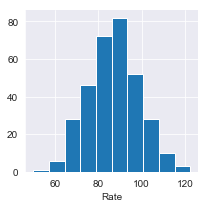

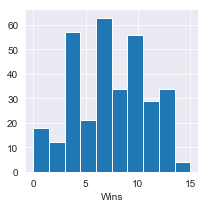

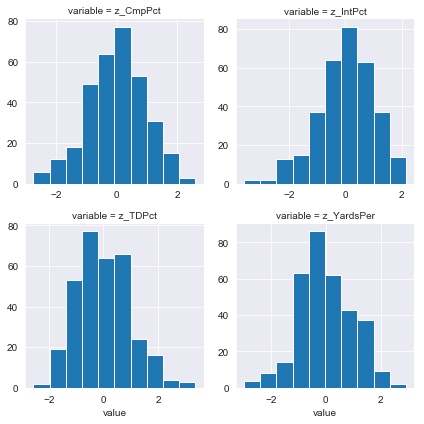

In [23]:
uniplot(qbdata,'qbdata')

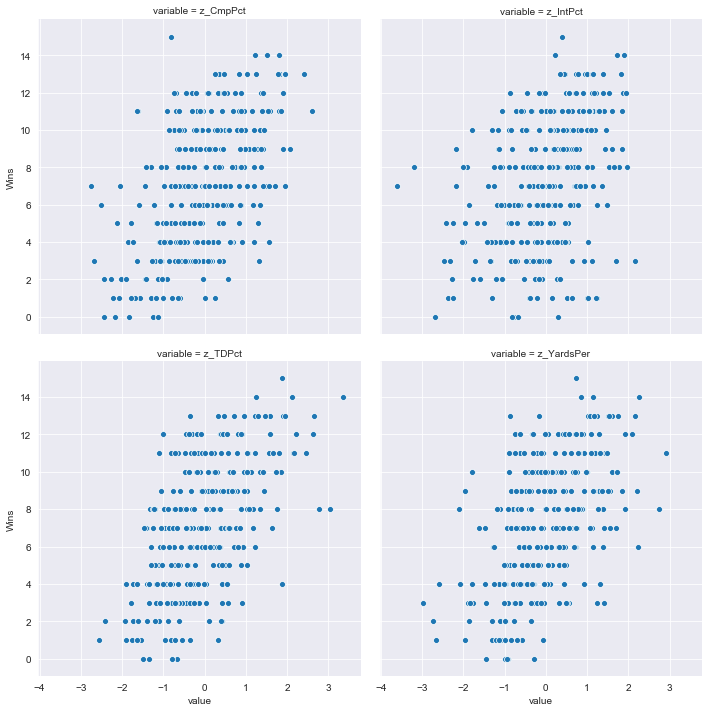

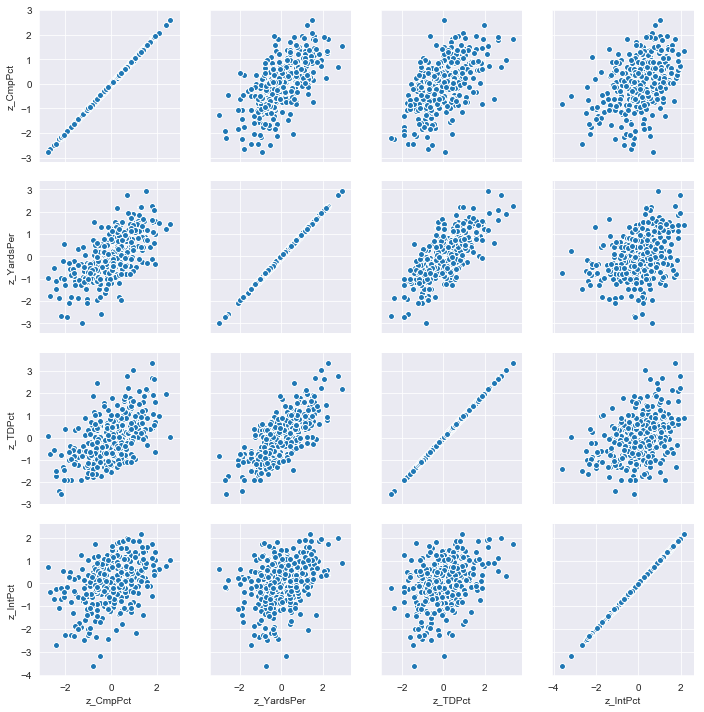

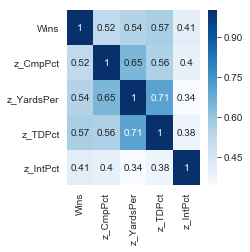

In [43]:
biplot(qbdata,'qbdata')

In [17]:
y, X = qbdata['Wins'], qbdata[['z_CmpPct', 'z_YardsPer', 'z_TDPct','z_IntPct']]
reg = LassoCV(cv=5).fit(X, y)
lasso = LassoCV(cv=5)
reg.score(X,y) 

0.41835287542994315

In [46]:
pd.DataFrame(list(zip(['z_CmpPct', 'z_YardsPer', 'z_TDPct','z_IntPct'],reg.coef_))).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>0</th>\n      <th>1</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>z_CmpPct</td>\n      <td>0.629119</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>z_YardsPer</td>\n      <td>0.587245</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>z_TDPct</td>\n      <td>0.975785</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>z_IntPct</td>\n      <td>0.620230</td>\n    </tr>\n  </tbody>\n</table>'

In [18]:
qbdata['PredictedWins'] = reg.predict(X)
sqrt(mean_squared_error(qbdata['Wins'],qbdata['PredictedWins']))

2.6296986990627436

In [19]:
salary = pd.read_html('https://www.spotrac.com/nfl/rankings/cap-hit/quarterback/')
salary = salary[0]
sa_name = salary['Player'].str.split(expand=True)
sa_name['Name'] = sa_name.iloc[:,0] + ' ' + sa_name.iloc[:,1]
salary = salary.join(sa_name)

In [20]:
week13['PredictedWins'] = reg.predict(week13[['z_CmpPct', 'z_YardsPer', 'z_TDPct','z_IntPct']])
data = week13.merge(salary[['cap hit','Name']],how='left', left_on='Name',right_on='Name')
data['cap hit'].replace(regex=r'\D+',value='',inplace=True)
data['cap hit'] = data['cap hit'].apply(pd.to_numeric)
data['Cap Hit/Predicted Win'] = data['cap hit']/data['PredictedWins']
data['Win Percentage'] = data['Wins']/data['G']

C:\Users\ptopp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


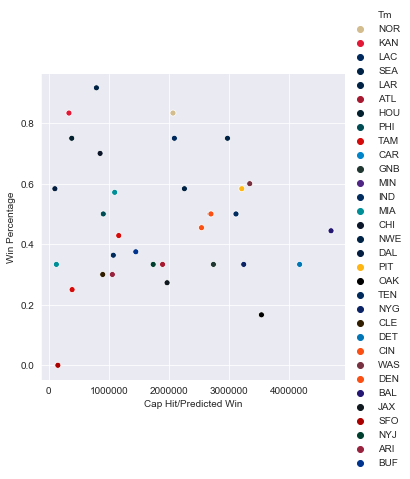

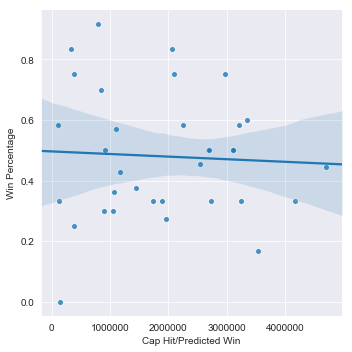

In [33]:
g = sns.relplot(kind='scatter', data=data, x='Cap Hit/Predicted Win', y='Win Percentage', hue='Tm', palette=nfl_pal)
g.savefig('scatterwins.png')
g = sns.lmplot(data=data, x='Cap Hit/Predicted Win', y='Win Percentage', scatter_kws={'edgecolors':'w'})
g.savefig('regwins.png')

In [21]:
data.sort_values('Cap Hit/Predicted Win').reset_index(drop=True).head(5).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Name</th>\n      <th>Tm</th>\n      <th>G</th>\n      <th>Cat</th>\n      <th>Wins</th>\n      <th>Rate</th>\n      <th>z_CmpPct</th>\n      <th>z_YardsPer</th>\n      <th>z_TDPct</th>\n      <th>z_IntPct</th>\n      <th>PredictedWins</th>\n      <th>cap hit</th>\n      <th>Cap Hit/Predicted Win</th>\n      <th>Win Percentage</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>Dak Prescott</td>\n      <td>DAL</td>\n      <td>12</td>\n      <td>Mediocre</td>\n      <td>7</td>\n      <td>95.4</td>\n      <td>0.319741</td>\n      <td>-0.300095</td>\n      <td>-0.750579</td>\n      <td>0.974850</td>\n      <td>7.083130</td>\n      <td>725848</td>\n      <td>102475.604152</td>\n      <td>0.583333</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>Brock Osweiler</td>\n      <td>MIA</td>\n      <td>6</td>\n      <td>Bad</td>\n      <td>2</td>\n      <

In [37]:
data.sort_values('Cap Hit/Predicted Win').reset_index(drop=True).tail(5).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Name</th>\n      <th>Tm</th>\n      <th>G</th>\n      <th>Cat</th>\n      <th>Wins</th>\n      <th>Rate</th>\n      <th>z_CmpPct</th>\n      <th>z_YardsPer</th>\n      <th>z_TDPct</th>\n      <th>z_IntPct</th>\n      <th>PredictedWins</th>\n      <th>cap hit</th>\n      <th>Cap Hit/Predicted Win</th>\n      <th>Win Percentage</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>29</th>\n      <td>Eli Manning</td>\n      <td>NYG</td>\n      <td>12</td>\n      <td>Mediocre</td>\n      <td>4</td>\n      <td>93.7</td>\n      <td>0.552332</td>\n      <td>-0.137565</td>\n      <td>-0.986767</td>\n      <td>0.564453</td>\n      <td>6.839892</td>\n      <td>22200000</td>\n      <td>3.245665e+06</td>\n      <td>0.333333</td>\n    </tr>\n    <tr>\n      <th>30</th>\n      <td>Alex Smith</td>\n      <td>WAS</td>\n      <td>10</td>\n      <td>Bad</td>\n      <td>6</td>\n      <t

C:\Users\ptopp\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ptopp\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptopp\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptopp\Anaconda3\lib\site-packages\ipy

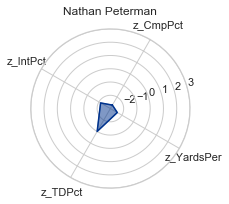

<Figure size 648x0 with 0 Axes>

<Figure size 648x0 with 0 Axes>

<Figure size 648x0 with 0 Axes>

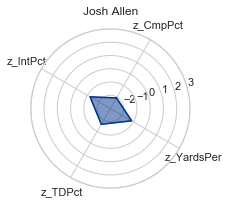

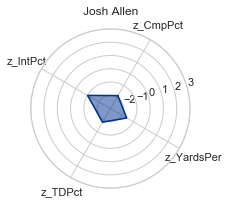

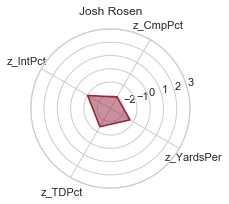

<Figure size 648x0 with 0 Axes>

In [84]:
for y in range(1,9):
    df = QBStats(NFLSpread,'Week {}!A1:AE'.format(y)).zscore()
    sheet = 'Week{}'.format(y)
    spider(df,sheet,'Train')


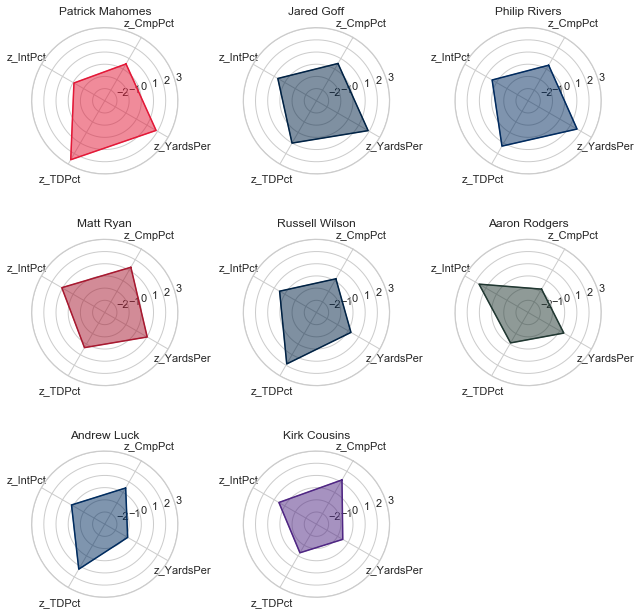

In [70]:
spider(x)